**Goal**<br>
The goal of this exercise is to investigate the effect of network width on the spectrum of the Neural Tangent Kernel (NTK) matrix for MSE loss.

The non-zero eigenvalues of the NTK matrix are equal to the non-zero eigenvalues of the Fisher information matrix (FIM). We will therefore approximate, using Lanczos, the spectrum of the FIM.

*Before you start, make sure to change the runtime type to include a GPU!*

<br>

**Task 0 (adding approximately 8 lines of code)**<br>
Repeat task 1 from the previous PyTorch coding exercise. Namely, implement the function *Lanczos*.

<br>

**Task 1 (adding around 4 lines of code)**<br>
Implement the function *FIM_vector_multiplication* which obtains as input a vector $v \in \mathbb{R}^p$ and multiplies the FIM $G$ by that vector, i.e. calculates $G v \in \mathbb{R}^{p}$. No for loops allowed.

Hints:
* use torch.autograd.grad three times
* read carefully the documentation of the function *torch.autograd.grad* in the following link: https://pytorch.org/docs/stable/autograd.html
* use the functions *list_to_vector* and *vector_to_list*

<br>

**Task 2 (changing one line of code)**<br>
A malicious individual purposefully planted a mistake in the code. Find the mistake and correct it.

<br> 

**Task 3**<br>
How does the spectrum of the NTK/FIM change throughout the epochs of SGD?

<br>

**Submission**<br>
*   Download your code by clicking File -> Download .ipynb
*   Submit your downloaded code on Quercus together with a PDF file of your code.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# hyperparameters
device      = "cuda"
batch_size  = 1024

poly_deg    = 128  # the higher the parameter the better the approximation
poly_points = 4096 # number of points in spectrum approximation
kappa       = 3    # contorls width of Gaussian bumps of spectrum

In [3]:
class LinearNeuralTangentKernel(nn.Linear): 
    def __init__(self, in_features, out_features, bias=True, beta=0.1, w_sig=1):
        self.beta = beta
        super(LinearNeuralTangentKernel, self).__init__(in_features, out_features)
        self.reset_parameters()
        self.w_sig = w_sig
      
    def reset_parameters(self):
        torch.nn.init.normal_(self.weight, mean=0, std=1)
        if self.bias is not None:
            torch.nn.init.normal_(self.bias, mean=0, std=1)

    def forward(self, input):
        return F.linear(input, self.w_sig * self.weight, self.beta * self.bias) / np.sqrt(self.weight.size(0))

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}, beta={}'.format(
            self.in_features, self.out_features, self.bias is not None, self.beta
        )

class MLP(nn.Module):
    def __init__(self, width, n_out=10, beta=0.1):
        super(MLP, self).__init__()
        self.fc1 = LinearNeuralTangentKernel(32**2, width, beta=beta)
        self.fc2 = LinearNeuralTangentKernel(width, width, beta=beta)
        self.fc3 = LinearNeuralTangentKernel(width, n_out, beta=beta)

    def forward(self, x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
def ApproximateSpectrum():
    model.eval()
    
    # Lanczos
    ritzVal, S, alpha, beta = Lanczos(poly_deg)
    
    # calculate lower bound (lb) and upper bound (ub) of spectrum
    theta_1 = ritzVal[0]
    theta_k = ritzVal[-1]
    
    s_1 = float(beta[-1]) * float(S[-1,0])
    s_k = float(beta[-1]) * float(S[-1,-1])
    
    lb = theta_1 - abs(s_1)
    ub = theta_k + abs(s_k)

    # pad a little bit the lower and upper bound
    margin = 0.05*(ub - lb)
    lb -= margin
    ub += margin

    # normalize eigenvalues to range [-1,1]
    c = (lb + ub)/2
    d = (ub - lb)/2
    ritzVal = (ritzVal - c) / d

    # width of Gaussian bumps
    H = 2 / (poly_deg - 1)
    sigma = H / np.sqrt(8 * np.log(kappa))
    w = sigma * np.sqrt(-2.0 * np.log(1e-08))

    # calculate spectrum approximation based on eigenvalues
    eigval = np.linspace(-1, 1, poly_points)
    diff = np.expand_dims(ritzVal,-1) - np.expand_dims(eigval,0)
    eigval_idx, pts_idx = np.where(np.abs(diff) < w)
    gamma2 = S[0,]**2
    vals = gamma2[eigval_idx]                                   \
         * np.exp(-((eigval[pts_idx] - ritzVal[eigval_idx])**2) \
         / (2 * sigma**2))
    density = np.zeros(poly_points)
    np.add.at(density, pts_idx, vals / np.sqrt((2 * sigma**2) * np.pi))
    
    # unnormalize spectrum approximation
    eigval = eigval*d + c
    density = density/d

    density *= p

    # plot spectrum
    plt.semilogy(eigval,density,label='width='+str(width))
    bottom, top = plt.ylim()
    plt.ylim((1e-4,top))

def Lanczos(M):
    v = torch.randn(p).to(device)
    v /= torch.norm(v)
    
    alpha = torch.zeros(M).to(device)
    beta = torch.zeros(M).to(device)
    
    v_prev = None
    
    for m in range(M):        
        # TASK 0: ADD CODE HERE
        if m == 0:
            v_next = FIM_vector_multiplication(v)
        else:
            v_next = FIM_vector_multiplication(v) - beta[m-1] * v_prev
        alpha[m] = torch.dot(v_next, v)
        v_next = v_next - alpha[m] * v
        beta[m] = torch.norm(v_next)
        v_next = v_next / beta[m]
        v_prev = v
        v = v_next
        
        
    B = np.diag(alpha.cpu().numpy()) + np.diag(beta.cpu().numpy()[:-1], k=1) + np.diag(beta.cpu().numpy()[:-1], k=-1)
    ritz_val, S = np.linalg.eigh(B)
    
    return ritz_val, S, alpha, beta

def list_to_vector(list_):
    return torch.cat([x.reshape(-1) for x in list_])

def vector_to_list(vector):
    list_ = []
    counter = 0
    for param in list(model.parameters()):
        list_.append(vector[counter:counter+torch.numel(param)].view(param.shape))
        counter += torch.numel(param)
    return list_

def FIM_vector_multiplication(v):
    Gv = 0
    counter = 0
    
    for iter, batch in enumerate(train_loader):
        input, target = batch[0], batch[1]
        
        input = input.to(device)
        target = target.to(device)
        
        logits = model(input)
        
        # TASK 1: ADD CODE HERE
        z = torch.ones((input.shape[0], 10), requires_grad=True).to(device)

        g1 = torch.autograd.grad(outputs=logits,
                                 inputs=model.parameters(),
                                 grad_outputs=z,
                                 create_graph=True)
        g1 = list_to_vector(g1)

        g2 = torch.autograd.grad(outputs=g1,
                                 inputs=z,
                                 grad_outputs=v,
                                 create_graph=True)

        g3 = torch.autograd.grad(outputs=logits,
                                 inputs=model.parameters(),
                                 grad_outputs=g2[0],
                                 create_graph=False)
        Gv += list_to_vector(g3)
        
        counter += input.shape[0]
    
    return Gv / counter

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Width:  16384
Width:  8192
Width:  512


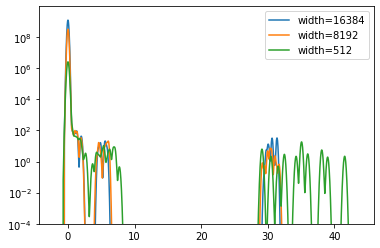

In [5]:
# dataset loaders
transform = transforms.Compose([transforms.Pad(2),
                                transforms.ToTensor(),
                                transforms.Normalize(0.2860,0.3530)])

dataset = datasets.FashionMNIST('../data', download=True, train=True, transform=transform)

# subsample dataset
subset = torch.utils.data.Subset(dataset, range(0, len(dataset), 200))

train_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                           shuffle=True, drop_last=False)

for width in [2**x for x in [14,13,9]]:
    print('Width: ',width)

    # deep network
    model = MLP(width=width).to(device)

    # total_number_of_parameters
    p = sum(param.numel() for param in model.parameters() if param.requires_grad)
    
    ApproximateSpectrum()
    
    del model

plt.legend()

# TASK 3:
# As the width grows, we observe two things:
# - the outliers of the spectrum are becoming concentrated around 30.
# - the bulk is becoming concentrated around 0.